In [115]:
import torch
import parameters_will
import torch.optim as optim
import RNN_Will as _model_
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils

%load_ext autoreload
%autoreload 2

# Set up our parameters
params = parameters_will.default_params()
params.data.freqs = [5,6,7,8,9]#,11,12,13,14,15]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'RNN or Not')

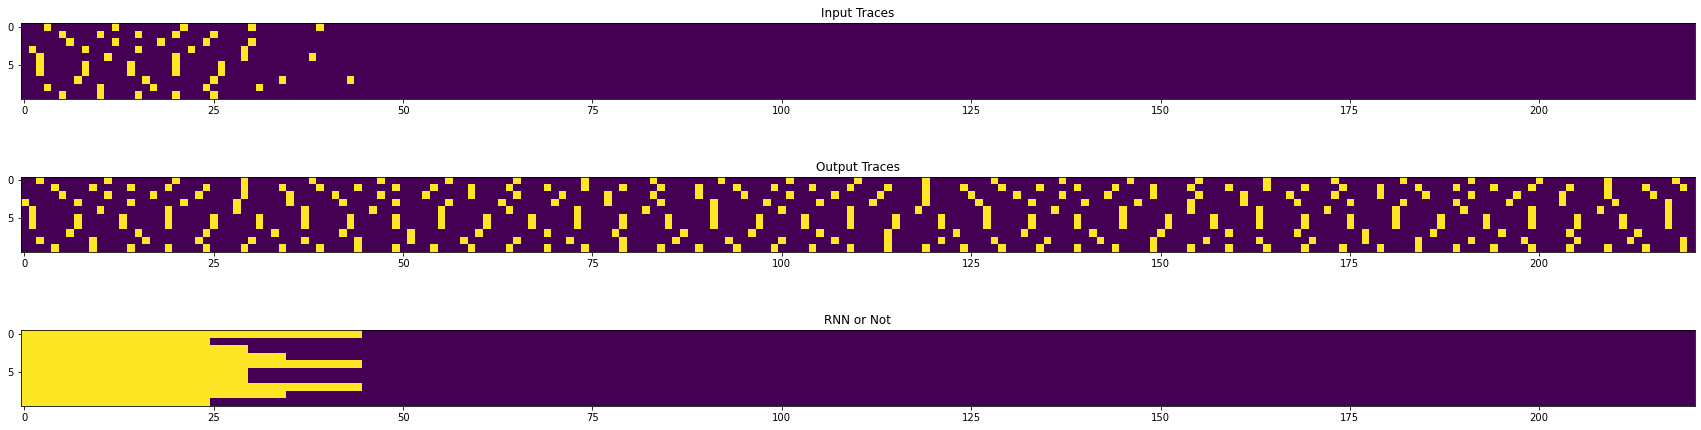

In [117]:
input_dict = utils.generate_data(params)
plt.figure(figsize = (30,8))
plt.subplot(3,1,1)
plt.imshow(input_dict.observation.T)
plt.title('Input Traces')

plt.subplot(3,1,2)
plt.imshow(input_dict.outputs.T)
plt.title('Output Traces')

plt.subplot(3,1,3)
plt.imshow(input_dict.input_or_rnn.T)
plt.title('RNN or Not')

[5, 6, 7, 8, 9]


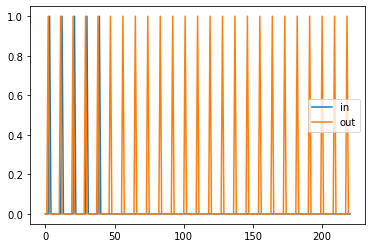

In [118]:
plt.plot(input_dict.observation[:,0],label='in')
plt.plot(input_dict.outputs[:,0],label='out')
plt.legend()

print(params.data.freqs)

In [ ]:
params.train.train_iters = 300000
print_iters = 100
reinitialise = 0

if reinitialise:
    # make instance of model
    model = _model_.VanillaRNN(params.model)
    # put model to gpu (if available)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Make an ADAM optimizer
    optimizer = optim.Adam(model.parameters(), lr=params.train.learning_rate, weight_decay=params.train.weight_decay)
else:
    model.batch_size = params.data.batch_size

min_loss = np.infty

for train_i in range(params.train.train_iters):

    # 1. Get input data, and convert to tensors (I have assumed you will put inputs etc into a dictionary)
    input_dict = utils.generate_data(params)#, freqs = np.full(params.data.batch_size, 7, dtype=int))
    
    # set all gradients to None
    # optimizer.zero_grad()
    for param in model.parameters():
        param.grad = None
        
    # forward pass
    variables = model(input_dict, device=device)
    
    # collate inputs for model
    (losses, loss_fit) = _model_.compute_losses_torch(input_dict, variables, model, params.train, device=device)

    # backward pass
    losses.backward()

    # clip gradients (you don't have to do this but it's a good idea for RNNs)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)

    optimizer.step()
    
    if losses.detach() < min_loss:
        min_loss = losses.detach()
        best_model = model
        print(f"{train_i}, new PB! {min_loss}")

    if train_i % print_iters == 0:
        print(f"{train_i}, {losses.item():.5f}, {loss_fit.item():.5f}, {losses.item()-loss_fit.item():.5f}")

0, new PB! 70.11784362792969
0, 70.11784, 38.28446, 31.83338
2, new PB! 66.9200439453125
3, new PB! 64.36044311523438
8, new PB! 60.39051818847656
22, new PB! 58.013301849365234
55, new PB! 57.64034652709961
56, new PB! 55.29589080810547
100, 67.17860, 33.85998, 33.31862
104, new PB! 53.6239013671875
144, new PB! 52.304725646972656
200, 58.52024, 31.45942, 27.06082
240, new PB! 50.88555145263672
300, 52.29114, 26.20147, 26.08967
354, new PB! 49.598365783691406
400, 54.16861, 29.48736, 24.68125
458, new PB! 48.411865234375
500, 52.77211, 27.74881, 25.02331
600, 60.13387, 30.93743, 29.19644
646, new PB! 48.31590270996094
700, 66.38719, 34.02483, 32.36236
800, 65.46906, 31.86832, 33.60074
894, new PB! 47.46625518798828
900, 97.94553, 73.35893, 24.58660
1000, 288.90408, 280.25229, 8.65179
1057, new PB! 47.390403747558594
1100, 132.50462, 109.11905, 23.38557
1200, 132.72633, 114.56403, 18.16231
1211, new PB! 47.35436248779297
1300, 67.73363, 41.95363, 25.78001
1343, new PB! 45.1209754943847

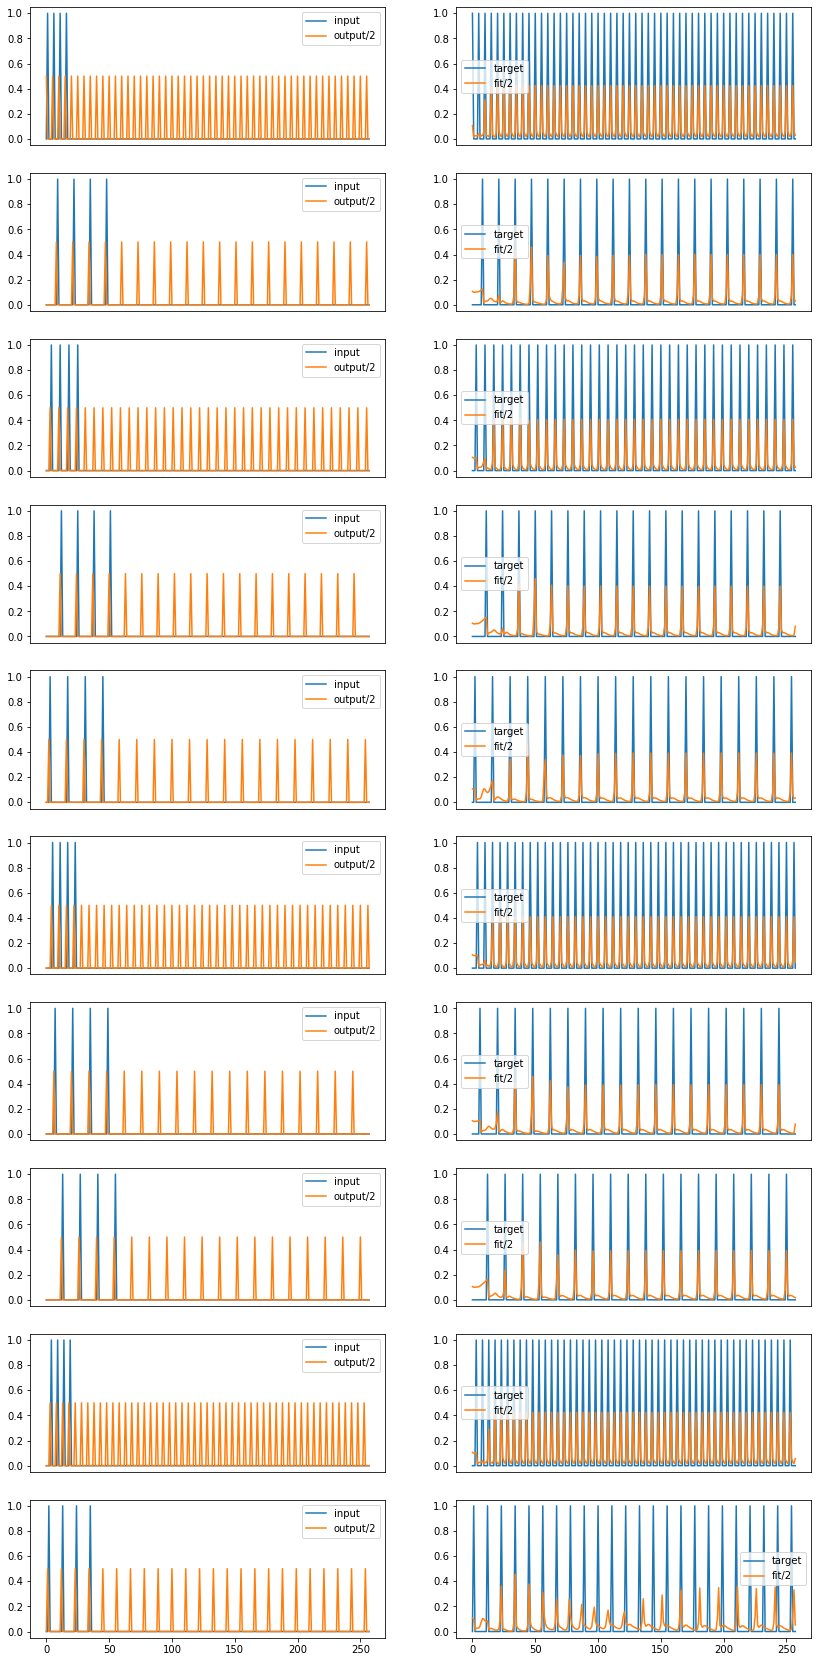

In [113]:
# Let's have a look at how one example is going
use_best = 0
if use_best:
    model_use = best_model
else:
    model_use = model
    
input_dict = utils.generate_data(params)#, freqs = np.full(params.data.batch_size, 7, dtype=int))

variables = model_use(input_dict, device=device)
output = torch.stack(variables.pred)
plt.figure(figsize=(14,3*params.data.batch_size))

for sample in range(params.data.batch_size):
    plt.subplot(params.data.batch_size,2,1+sample*2)
    #plt.title(f'Desired Function, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.observation[:,sample],label='input')
    plt.plot(0.5*input_dict.outputs[:,sample],label='output/2')
    plt.legend()
    if sample < params.data.batch_size-1:
        plt.xticks([])
        
    plt.subplot(params.data.batch_size,2,2+sample*2)
    #plt.title(f'Network Behaviour, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.outputs[:,sample], label='target')
    plt.plot(0.5*output.detach().numpy()[:,sample,0], label = 'fit/2')
    plt.legend()
    if sample < params.data.batch_size-1:
        plt.xticks([])